# Transform data


Transforms the datasets we have to .xyz format, so they are compatible with the CryinGAN repository.

In [116]:
import os
import ase
from ase.io import read, write
import numpy as np
import shutil
from pathlib import Path
from tqdm import tqdm

%cd ..
from src.utils import load_raw_data, read_raw_sample

from CCGAN.tools import BatchDistance2D, BatchDistance

%cd -

import torch

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


/Users/veikko/Documents/GitHub/hard-spheres/CCGAN/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [40]:
def makedir_if_not_exists(path):
    try:
        if not os.path.isdir(path):
            print("Creating directory {}".format(path))
            os.mkdir(path)
    except OSError:
        print("Creation of the directory %s failed" % path)
        makedir_if_not_exists(path.parent) # Recursive call to create parent directory
    return

path = Path("../data/raw/crystal/Sq")
path = Path("../data/raw/samples")


phis = [
    0.70,
    0.72,
    0.74,
    0.76,
    0.78,
    0.80,
    # 0.81, # Left out on purpose to enable testing interpolation 
    0.82,
    0.83,
    0.84,
    0.85,
    0.86,
    # 0.8625 # Left out on purpose to enable testing extrapolation
    ]

# Low packing fraction 0.70
#    2. Mid 0.78
#    3. High packing fraction 0.84
#    4. Very high 0.86

files, dataframe, metadata = load_raw_data(path, phi=phis, subpath="")

Loading data from /Users/veikko/Documents/GitHub/hard-spheres/data/raw/samples
Number of Files found :  4721


In [41]:
import pandas as pd

SCALING_FACTOR = 1 # The largest distance in the system is a bit over 47 so we scale it down to <1

max_files = np.inf # NOTE: Limit the amount of data to speed up training

input_paths = [file for file in files]
output_paths = {input_paths[i]: Path(str(input_paths[i]).replace("raw", "processed")).parent for i in range(len(input_paths))}

for path in output_paths.values():
    # Remove the folder if it exists
    if path.is_dir():
        print("Removing folder {}".format(path))
        shutil.rmtree(path)


for i, file in tqdm(enumerate(files), total=len(files)):
    dataframe, metadata = read_raw_sample(file)

    output_folder = output_paths[file]

    output_folder.mkdir(parents=True, exist_ok=True)

    output_samples = output_folder / "samples.extxyz"
    output_metadata = output_folder / "metadata.csv"
    radius_file = output_folder / "radius.csv"

    xyz = dataframe[["class", "x", "y"]].reset_index(drop=True)
    r = dataframe[["r"]].reset_index(drop=True) / SCALING_FACTOR # NOTE: Scale with 50

    N = metadata.iloc[0,0] # N particles

    phi, sample = dataframe.index.unique()[0]
    phi_value = float(phi.split("-")[-1])
    xyz["z"] = 0

    # Create an ASE Atoms object

    L = metadata["L"].iloc[0] / SCALING_FACTOR # NOTE: Scale with 50

    # NOTE: Radius is not right
    atoms = ase.Atoms(
        numbers=xyz["class"].values,
        positions=(xyz[["x", "y", "z"]].values / SCALING_FACTOR)+[L/2, L/2, 0], # NOTE: Displace the system
        cell=[L, L, 0], # NOTE: 2D system
        pbc=[True, True, False], # NOTE: 2D system
        info={
            "phi": phi_value,
            "sample": sample,
            "N": N,
            "L": L,
            "SCALING_FACTOR": SCALING_FACTOR},#, "r": r["r"].values},
    )
    atoms.new_array('rmt', r.values)

    # Save to xyz file
    # NOTE: This is the format used by ASE

    with open(output_samples, "a+") as f:
        write(f, atoms, format="extxyz", append=True)

    atoms_flipped = ase.Atoms(
        numbers=xyz["class"].values,
        positions=(xyz[["x", "y", "z"]].values / SCALING_FACTOR)+[L/2, L/2, 0], # NOTE: Displace the system
        cell=[L, L, 0], # NOTE: 2D system
        pbc=[True, True, False], # NOTE: 2D system
        info={
            "phi": phi_value,
            "sample": sample,
            "N": N,
            "L": L,
            "SCALING_FACTOR": SCALING_FACTOR},#, "r": r["r"].values},
    )
    atoms_flipped.new_array('rmt', r.values)

    # Save to xyz file
    # NOTE: This is the format used by ASE

    with open(output_samples, "a+") as f:
        write(f, atoms_flipped, format="extxyz", append=True)


    pd.DataFrame(
        {
            "phi": [phi_value],
            "sample": [sample],
            "N": [N],
            "L": [L],
        }
    ).to_csv(
        output_metadata,
        header=False,
        index=False,
        sep="\t",
        mode="a+",
    )
    
    if i > max_files:
        break


display(dataframe.head(10))
metadata

Removing folder ../data/processed/samples/phi-0.70
Removing folder ../data/processed/samples/phi-0.72
Removing folder ../data/processed/samples/phi-0.74
Removing folder ../data/processed/samples/phi-0.76
Removing folder ../data/processed/samples/phi-0.78
Removing folder ../data/processed/samples/phi-0.80
Removing folder ../data/processed/samples/phi-0.82
Removing folder ../data/processed/samples/phi-0.83
Removing folder ../data/processed/samples/phi-0.84
Removing folder ../data/processed/samples/phi-0.85
Removing folder ../data/processed/samples/phi-0.86


100%|██████████| 4721/4721 [01:33<00:00, 50.33it/s]


class          x          y         r
experiment sample                                           
phi-0.86   sample-468      7 -18.184194 -11.054786  1.011053
           sample-468     18  -1.913897 -13.394813  1.526316
           sample-468      2  -4.446339  -9.424827  0.776842
           sample-468      3   0.491822   3.859376  0.823684
           sample-468     17   8.828759  -4.184055  1.479474
           sample-468      7   6.491512  -1.142022  1.011053
           sample-468      9   3.209332   0.362879  1.104737
           sample-468      6  -2.420658  -5.547575  0.964211
           sample-468      2  -2.479958  -9.151167  0.776842
           sample-468      2  -1.562861   6.509475  0.776842

,,N,L,A
experiment,sample,,,
phi-0.86,sample-468,2000,43.493059,1626.815709


Reading file:  ../data/processed/samples/phi-0.70/samples.extxyz


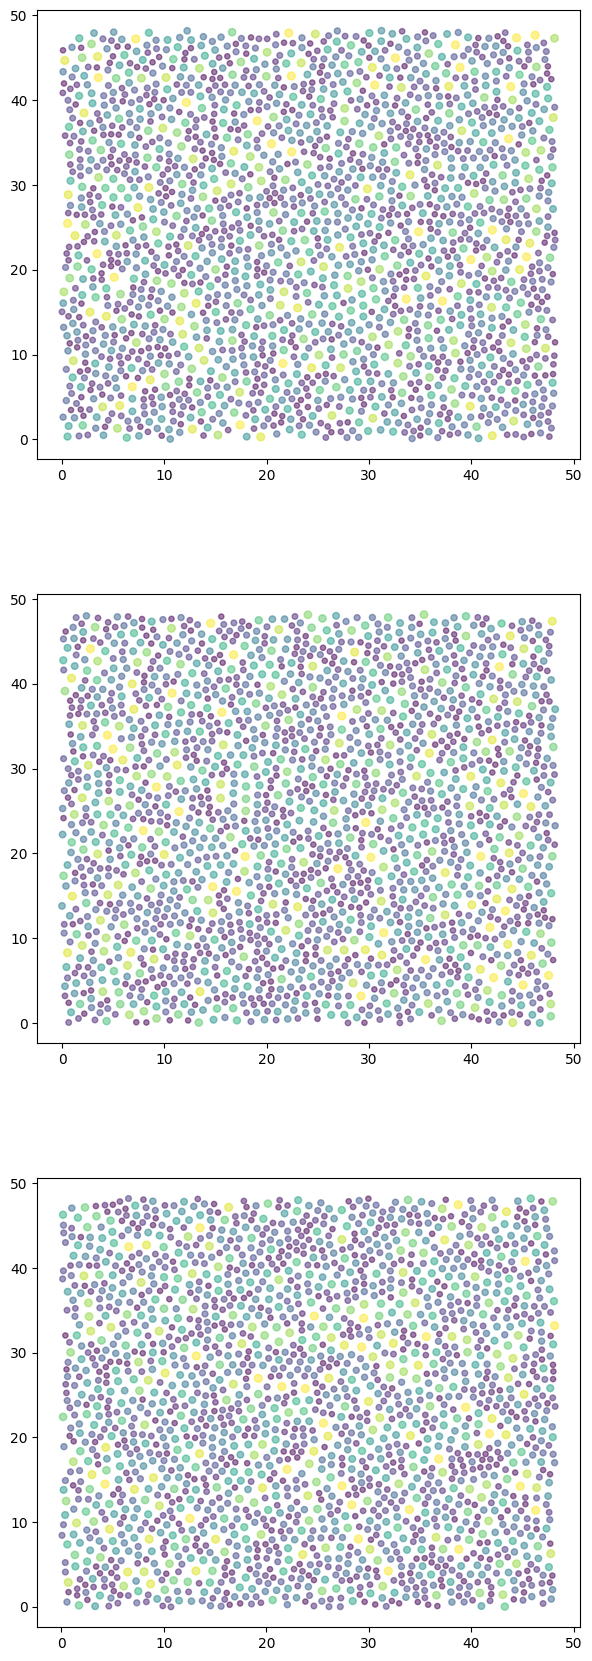

In [47]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

PHI = "0.70"

padded_phi = format(float(PHI), ".2f")

file = f"../data/processed/samples/phi-{padded_phi}/samples.extxyz"

print("Reading file: ", file)

all_atoms = read(file, index=":", format="extxyz")
idxs = [0,5,19]

fig = plt.figure(figsize=(7, 7*len(idxs)))
gs  = gridspec.GridSpec(len(idxs), 1, hspace=0.3)

# top row: two scatter plots

for i, idx in enumerate(idxs):
    np_coords = all_atoms[idx].get_positions()
    radii = all_atoms[idx].get_array("rmt")

    ax_gen = fig.add_subplot(gs[i])
    ax_gen.scatter(
        np_coords[:,0],
        np_coords[:,1],
        c=radii, s=radii*20, alpha=0.5
    )

Reading file:  ../data/processed/samples/phi-0.86/samples.extxyz


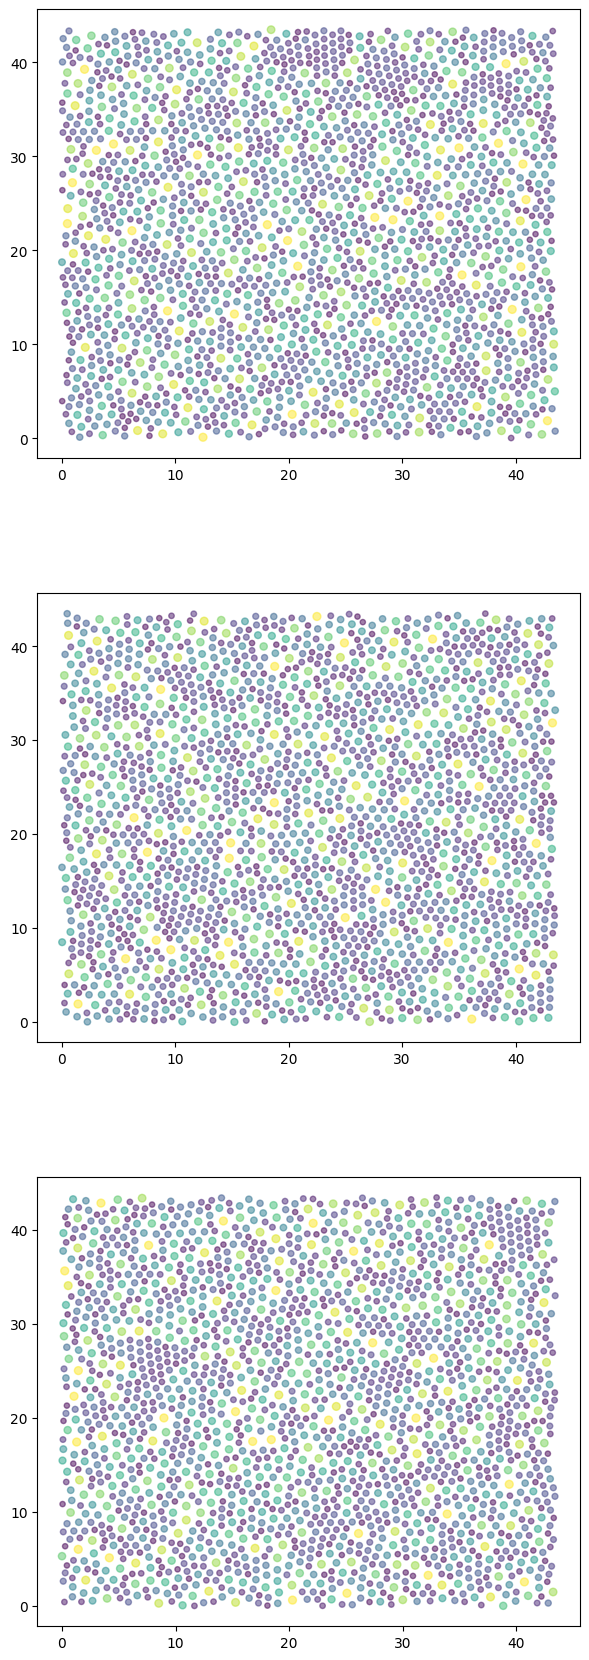

In [46]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

PHI = "0.86"

padded_phi = format(float(PHI), ".2f")

file = f"../data/processed/samples/phi-{padded_phi}/samples.extxyz"

print("Reading file: ", file)

all_atoms = read(file, index=":", format="extxyz")
idxs = [0,5,19]

fig = plt.figure(figsize=(7, 7*len(idxs)))
gs  = gridspec.GridSpec(len(idxs), 1, hspace=0.3)

# top row: two scatter plots

for i, idx in enumerate(idxs):
    np_coords = all_atoms[idx].get_positions()
    radii = all_atoms[idx].get_array("rmt")

    ax_gen = fig.add_subplot(gs[i])
    ax_gen.scatter(
        np_coords[:,0],
        np_coords[:,1],
        c=radii, s=radii*20, alpha=0.5
    )

In [44]:
# Check the  ASE Atoms object to make sure the cell sizes are correct
from ase.visualize import view

atoms = all_atoms[0]

atoms.get_cell(), atoms.get_positions().max()


(Cell([43.4930589071005, 43.4930589071005, 0.0]), 43.48477338)

Works

# Make sure BatchDistance2D works too

## Minimal smoke test, should print 0.5

In [ ]:
import torch
from torch.utils.data import DataLoader

# simple 2-atom motif in a square cell of side 1.0
lat = torch.eye(3)
coords = torch.tensor([[[[0.25, 0.25, 0.0],
                         [0.75, 0.25, 0.0]]]])  # shape (1,1,2,3)

ds2d = BatchDistance2D(coords, n_neighbors=4, lat_matrix=lat)
out = ds2d.append_dist()  
# out shape (1,1,2,3+1) → last column is the nearest‐neighbor distance
print(out)  
# should be 0.50 exactly (half the cell in x), for both atoms


tensor([[[[0.2500, 0.2500, 0.0000, 0.5000, 0.5000, 1.0000, 1.0000],
          [0.7500, 0.2500, 0.0000, 0.5000, 0.5000, 1.0000, 1.0000]]]])
